In [256]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import dill
from tqdm import tqdm
from triangle import triangulate
from random import choice, sample
import sympy
from matplotlib import cm

### Load precomputed integrals

In [257]:
poisson_finctional = dill.load(
    open("../calculations/hermite_cubic_poisson_matrix", "rb")
)
integral_values = dill.load(
    open("../calculations/hermite_cubic_poisson_right_values", "rb")
)

### Initialize the domain

In [261]:
t = np.linspace(0 + np.pi / 4, 2 * np.pi + np.pi / 4, 10, endpoint=False)
points = np.stack((np.cos(t), np.sin(t))).T

seg = np.array(
    [[j, j + 1] for j in range(points.shape[0] - 1)] + [[points.shape[0] - 1, 0]]
)

### Run triangulation

In [262]:
cndt = triangulate({"vertices": points, "segments": seg}, opts="pq30a0.9neo1s")
points = cndt["vertices"]
triangles = cndt["triangles"]
neighbours = cndt["neighbors"]
vertex_marker_is_boundary = cndt["vertex_markers"]
edges = cndt["edges"]
edge_marker_is_boundary = cndt["edge_markers"]

print(f"Total number of points {points.shape[0]}")

Total number of points 11


### Visualize the triangulation

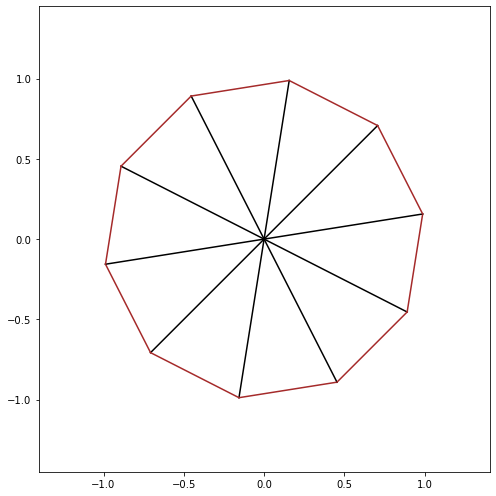

In [263]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(7, 7))
ax.axis("equal")

cl = ["black", "brown"]

for eidx, edge in enumerate(edges):
    ax.plot(
        points[edge][:, 0],
        points[edge][:, 1],
        color=cl[edge_marker_is_boundary[eidx][0]],
    )

ax.set_xlim([points[:, 0].min() - 1 / 2, points[:, 0].max() + 1 / 2])
ax.set_ylim([points[:, 1].min() - 1 / 2, points[:, 1].max() + 1 / 2])

fig.tight_layout()
plt.tight_layout()

plt.show()

In [264]:
x, y = sympy.symbols("x y", real=True)

In [265]:
right_part_values = np.zeros((points.shape[0], 3))

In [266]:
F = sympy.Float(1)
F_x = F.diff(x)
F_y = F.diff(y)

In [267]:
right_part_values[:, 0] = sympy.lambdify((x, y), F)(*points.T)
right_part_values[:, 1] = sympy.lambdify((x, y), F_x)(*points.T)
right_part_values[:, 2] = sympy.lambdify((x, y), F_y)(*points.T)

In [268]:
matrix = np.zeros((3 * points.shape[0], 3 * points.shape[0]))
b = np.zeros(3 * points.shape[0])

for idx, element in enumerate(tqdm(triangles)):
    x1, x2, x3 = points[element[0], 0], points[element[1], 0], points[element[2], 0]
    y1, y2, y3 = points[element[0], 1], points[element[1], 1], points[element[2], 1]

    delta = x1 * y2 - x1 * y3 - x2 * y1 + x2 * y3 + x3 * y1 - x3 * y2

    P_1_x = (+y2 - y3) / delta
    P_1_y = (-x2 + x3) / delta

    P_2_x = (+y3 - y1) / delta
    P_2_y = (-x3 + x1) / delta

    arg = [P_1_x, P_1_y, P_2_x, P_2_y]
    right = right_part_values[element].flatten()

    FF = poisson_finctional(*arg, *right)
    ff = integral_values(*arg, *right)

    for local_point in range(3):
        if vertex_marker_is_boundary[element[local_point]] == True and (
            (points[element[local_point]] ** 2).sum() > 0.1
        ):
            matrix[3 * element[local_point] + 0, 3 * element[local_point] + 0] = 1

            for degree in range(1, 3):
                for other_point in range(3):
                    for other_degree in range(3):
                        matrix[
                            3 * element[local_point] + degree,
                            3 * element[other_point] + other_degree,
                        ] += (
                            2
                            * FF[
                                3 * local_point + degree, 3 * other_point + other_degree
                            ]
                        )

            b[3 * element[local_point] + 0] = 0
            b[3 * element[local_point] + 1] -= 2 * ff[3 * local_point + 1]
            b[3 * element[local_point] + 2] -= 2 * ff[3 * local_point + 2]

        else:
            for degree in range(3):
                for other_point in range(3):
                    for other_degree in range(3):
                        matrix[
                            3 * element[local_point] + degree,
                            3 * element[other_point] + other_degree,
                        ] += (
                            2
                            * FF[
                                3 * local_point + degree, 3 * other_point + other_degree
                            ]
                        )

            b[3 * element[local_point] + 0] -= 2 * ff[3 * local_point + 0]
            b[3 * element[local_point] + 1] -= 2 * ff[3 * local_point + 1]
            b[3 * element[local_point] + 2] -= 2 * ff[3 * local_point + 2]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 231.52it/s]


In [ ]:
c = np.linalg.solve(matrix, b)

In [250]:
U = -(1 - x**2 - y**2) / 4
U_x = sympy.lambdify((x, y), U.diff(x))(*points.T)
U_y = sympy.lambdify((x, y), U.diff(y))(*points.T)
U = sympy.lambdify((x, y), U)(*points.T)

In [251]:
_x_ = points[:, 0]
_y_ = points[:, 1]
F = c[0::3]
Fx = c[1::3]
Fy = c[2::3]

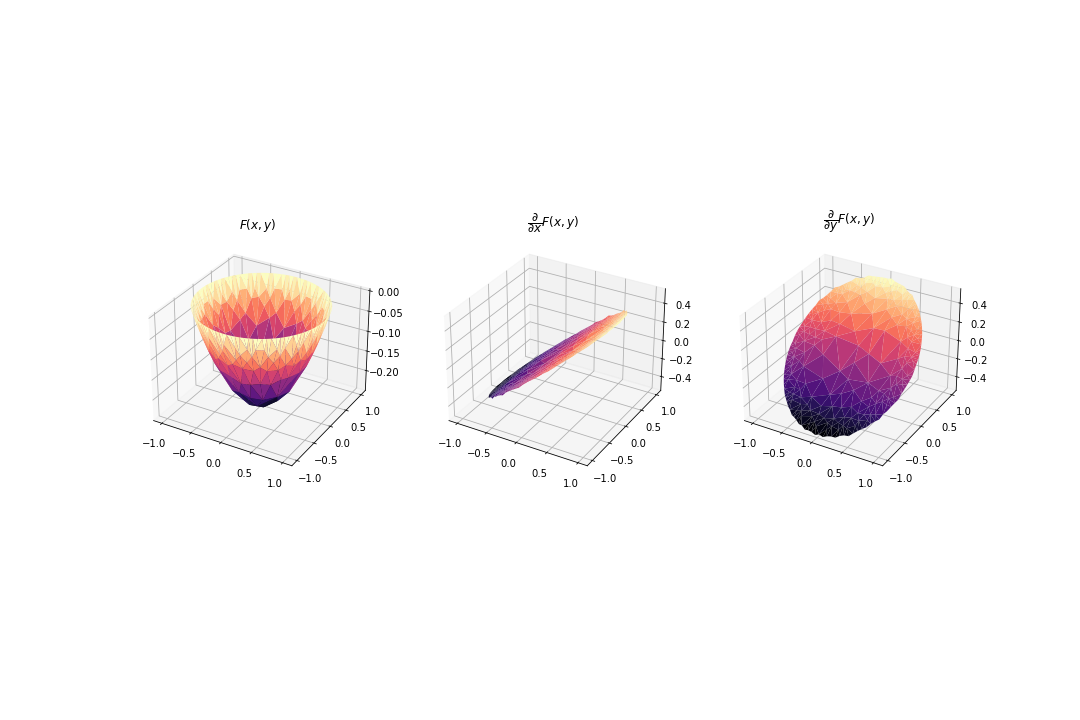

In [252]:
%matplotlib widget
fig, ax = plt.subplots(1, 3, figsize=(15, 10), subplot_kw=dict(projection="3d"))
plot_1 = ax[0].plot_trisurf(_x_, _y_, F, triangles=triangles, cmap=cm.magma)
ax[0].set_title(r"$F\left(x, y\right)$")
plot_2 = ax[1].plot_trisurf(_x_, _y_, Fx, triangles=triangles[:, :3], cmap=cm.magma)
ax[1].set_title(r"$\dfrac{\partial}{\partial x}F\left(x, y\right)$")
plot_3 = ax[2].plot_trisurf(_x_, _y_, Fy, triangles=triangles[:, :3], cmap=cm.magma)
ax[2].set_title(r"$\dfrac{\partial}{\partial y}F\left(x, y\right)$")
plt.show()

### $ \lVert F - \hat{F} \rVert_{\infty}$

In [253]:
abs(U - F).max()

0.0001782879564178122

### $ \lVert F_{x} - \hat{F}_{x} \rVert_{\infty}$

In [254]:
abs(U_x - Fx).max()

0.034653666928961324

### $ \lVert F_{y} - \hat{F}_{y} \rVert_{\infty}$

In [255]:
abs(U_y - Fy).max()

0.035183735029187035